In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting too

#pre-trained sentiment analyser
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LONPA14\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [3]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bi_mod):
    return [bi_mod[doc] for doc in texts]

def make_trigrams(texts,tri_mod):
    return [tri_mod[bi_mod[doc]] for doc in texts]

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'to'])

In [5]:
import nltk
def stem_with_porter(words):
    porter = nltk.PorterStemmer()
    new_words = [porter.stem(w) for w in words]
    return new_words

# GUMMO Analysis

In [6]:
df_gummo = pd.read_csv("69_GUMMO_comments.csv")
df_gummo.head()

,comment
0,I’m just imagining 50 year old white women lis...
1,The biggest flex was hearing this song as soon...
2,"2:14 ""Damn, forgot my mask"""
3,Who like 6ix9ine old style??
4,He made this song when he found out that he is...


In [7]:
ls_gummo = df_gummo["comment"].tolist()
ls_gummo

['I’m just imagining 50 year old white women listening to this in court',
 'The biggest flex was hearing this song as soon as it came out.',
 '2:14 "Damn, forgot my mask"',
 'Who like 6ix9ine old style??',
 'He made this song when he found out that he is 1% black',
 'when ancestry says you’re 0.0001 percent black.',
 'No joke man even though we hate him this song still is hard af',
 'Yall cant even lie this song was turnt af when we first heard it 🤣🤣🔥🔥🔥',
 'imagine walking home from school and seeing them make this',
 "There is a reason why the lyrics aren't in the description",
 'Hands down the best skittle commercial',
 'You can’t lie even if we hate 6ix9ine this song still hits',
 '2:15\nMom: Get YO ASS BACK IN THE HOUSE.',
 'Fun fact: this ain’t your first time listening to this',
 'CEO of using the n-word',
 '2:14 when you hear that there is a Coronavirus vaccine but you can’t get it yet',
 'I just realized he got 47 years when he was 22 when he got out was gonna be 69',
 'I forgo

In [8]:
tokenized_gummo = list(sent_to_words(ls_gummo))

In [9]:
# Build the bigram and trigram models
bigram_gummo = gensim.models.Phrases(tokenized_gummo, min_count=2, threshold=20) # higher threshold fewer phrases.
trigram_gummo = gensim.models.Phrases(bigram_gummo[tokenized_gummo], threshold=20)  


bigram_mod_gummo = gensim.models.phrases.Phraser(bigram_gummo)
trigram_mod_gummo = gensim.models.phrases.Phraser(trigram_gummo)

In [10]:
# Remove Stop Words
data_words_nostops_gummo = remove_stopwords(tokenized_gummo)

# Form Bigrams
data_words_bigrams_gummo = make_bigrams(data_words_nostops_gummo, bigram_mod_gummo)

data_words_bigrams_gummo1 = [item for sublist in data_words_bigrams_gummo for item in sublist]

### a. Word Count

In [11]:
data_df_gummo = pd.DataFrame.from_dict(data_words_bigrams_gummo1)
data_dfC_gummo = pd.DataFrame(data_df_gummo[0].value_counts())
data_dfC_gummo = data_dfC_gummo.reset_index()
data_dfC_gummo.rename(columns={"index": "Word", 0: "Frequency"}, inplace = True)

In [12]:
data_dfC_gummo.head(21)[1:]

,Word,Frequency
1,song,76
2,like,55
3,video,54
4,judge,52
5,know,47
6,love,46
7,good,40
8,still,40
9,one,37
10,gang,35


### b. Comment Length

In [13]:
df_gummo_length = pd.DataFrame([[element,len(element)] for element in ls_gummo], columns = ["GUMMO Comment", "Length"])
df_gummo_length.head()

,GUMMO Comment,Length
0,I’m just imagining 50 year old white women lis...,69
1,The biggest flex was hearing this song as soon...,62
2,"2:14 ""Damn, forgot my mask""",27
3,Who like 6ix9ine old style??,28
4,He made this song when he found out that he is...,55


In [14]:
df_gummo_length["Length"].mean()

42.62435897435898

### c. Sentiment Analysis

In [15]:
#stemming words
data_words_bigrams_stem_gummo = [stem_with_porter(x) for x in data_words_bigrams_gummo]
ls_gummo2 = [' '.join(x) for x in data_words_bigrams_stem_gummo]

In [16]:
sid = SentimentIntensityAnalyzer()
d = [0]*len(ls_gummo2)
for i in range(len(ls_gummo2)):
    d[i] = list(sid.polarity_scores(ls_gummo2[i]).values())[3]
df_gummo_sentiment = pd.DataFrame([[ls_gummo2[i],d[i]] for i in  range(len(ls_gummo2))],\
                                  columns = ["Comment", "Sentiment"])
df_gummo_sentiment["Sentiment"].mean()

0.046506794871794876

In [17]:
df_gummo_sentiment["Sentiment"].max()

0.9612

In [18]:
df_gummo_sentiment["Sentiment"].min()

-0.875

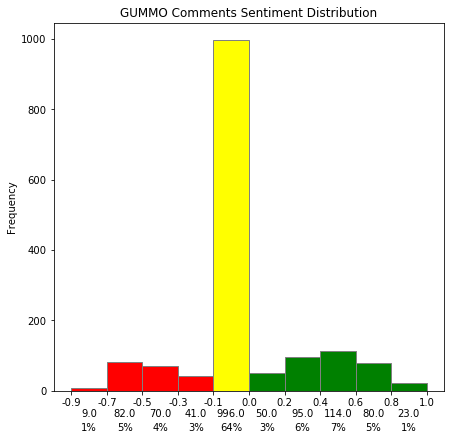

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
sentim_gummo = df_gummo_sentiment["Sentiment"].tolist()
fig, ax = plt.subplots(figsize=(7,7))
counts, bins, patches = ax.hist(sentim_gummo, facecolor='yellow', edgecolor='gray')

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)
# Set the xaxis's tick labels to be formatted with 1 decimal place...
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# Change the colors of bars at the edges...
twentyfifth, seventyfifth = np.percentile(sentim_gummo, [25, 75])
for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
    if rightside < twentyfifth:
        patch.set_facecolor('red')
    elif leftside > seventyfifth:
        patch.set_facecolor('green')

# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.15)
ax.title.set_text('GUMMO Comments Sentiment Distribution')
ax.set_ylabel("Frequency")
plt.show()

# GOOBA Analysis

In [20]:
df_gooba = pd.read_csv("69_GOOBA_comments.csv")
df_gooba.head()

,comment
0,"Court: ""You're gonna stay in jail for 47 years..."
1,That’s amazing how the camera man filmed this ...
2,Those girls have more operations than my math ...
3,"Everyone: wants to go outside\n\n\nCorona: "" a..."
4,Kindergartners during art class:


In [21]:
ls_gooba= df_gooba["comment"].tolist()
ls_gooba

['Court: "You\'re gonna stay in jail for 47 years!"\n6ix9ine: "Are you dumb, stupid or dumb?"',
 'That’s amazing how the camera man filmed this with one hand!! 😂',
 'Those girls have more operations than my math notebook',
 'Everyone: wants to go outside\n\n\nCorona: " are u dumb, stupid, or dumb huh?"',
 'Kindergartners during art class:',
 'Director: How many colours you want for the shoot\n6ix9ine: are you dumb, stoopid, or dumb?',
 'This guy laughed at our faces with a rat on his head. Dang',
 'If the Teletubbies and Nicki Minaj had kids:',
 'Everyone: He’s getting 49 years to life in prison.\n\n1 Year Later -\n\n100M in 72 hours',
 'This song said: 🌈🍑🌈🍑🌈🍑🌈🍑🌈🍑🌈🍑🌈🍑🌈🍑🌈',
 'He hasn’t changed at all lmfao',
 '49% English \n1% Spanish \n50% Plastic',
 "Not even coronavirus can kill this man's career",
 'That Ankle Bracelet is a paid actor',
 'Mom : do these dishes \nMe : no\nThe belt : are u dumb , stupid or dumb .. huh ?',
 'This man literally distrupted the youtube  algorithms like no

In [22]:
tokenized_gooba = list(sent_to_words(ls_gooba))

In [23]:
# Build the bigram and trigram models
bigram_1 = gensim.models.Phrases(tokenized_gooba, min_count=2, threshold=20) # higher threshold fewer phrases.
trigram_1 = gensim.models.Phrases(bigram_1[tokenized_gooba], threshold=20)  
bigram_mod_gooba= gensim.models.phrases.Phraser(bigram_1)
trigram_mod_gooba = gensim.models.phrases.Phraser(trigram_1)

In [24]:
# Remove Stop Words
data_words_nostops_gooba = remove_stopwords(tokenized_gooba)

# Form Bigrams
data_words_bigrams_gooba = make_bigrams(data_words_nostops_gooba, bigram_mod_gooba)

### a. Word Count

In [25]:
data_words_bigrams_gooba1 = [item for sublist in data_words_bigrams_gooba for item in sublist]
data_df_gooba = pd.DataFrame.from_dict(data_words_bigrams_gooba1)
data_dfC_gooba = pd.DataFrame(data_df_gooba[0].value_counts())
data_dfC_gooba = data_dfC_gooba.reset_index()
data_dfC_gooba.rename(columns={"index": "Word", 0: "Frequency"}, inplace = True)

### b. Comment Length

In [26]:
df_gooba_length = pd.DataFrame([[element,len(element)] for element in ls_gooba], columns = ["GOOBA Comment", "Length"])
df_gooba_length.head()

,GOOBA Comment,Length
0,"Court: ""You're gonna stay in jail for 47 years...",89
1,That’s amazing how the camera man filmed this ...,63
2,Those girls have more operations than my math ...,54
3,"Everyone: wants to go outside\n\n\nCorona: "" a...",75
4,Kindergartners during art class:,32


In [27]:
df_gooba_length["Length"].mean()

50.15064102564103

### c. Sentiment Analysis

In [28]:
#stemming words
data_words_bigrams_stem_gooba = [stem_with_porter(x) for x in data_words_bigrams_gooba]
ls_gooba2 = [' '.join(x) for x in data_words_bigrams_stem_gooba]

In [29]:
sid = SentimentIntensityAnalyzer()
d = [0]*len(ls_gooba2)
for i in range(len(ls_gooba2)):
    d[i] = list(sid.polarity_scores(ls_gooba2[i]).values())[3]
df_gooba_sentiment = pd.DataFrame([[ls_gooba2[i],d[i]] for i in  range(len(ls_gooba2))],\
                                  columns = ["Comment", "Sentiment"])
df_gooba_sentiment["Sentiment"].mean()

0.04179826923076923

In [30]:
df_gooba_sentiment["Sentiment"].max()

0.9493

In [31]:
df_gooba_sentiment["Sentiment"].min()

-0.8957

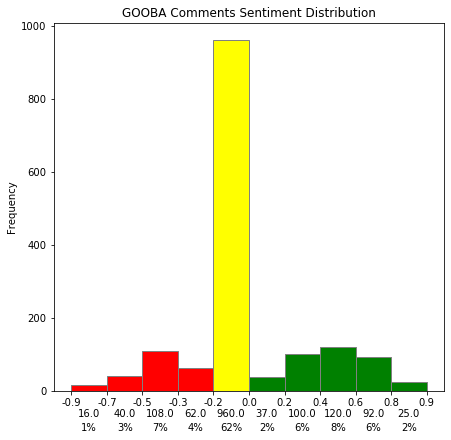

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
sentim_gooba = df_gooba_sentiment["Sentiment"].tolist()
fig, ax = plt.subplots(figsize=(7,7))
counts, bins, patches = ax.hist(sentim_gooba, facecolor='yellow', edgecolor='gray')

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)
# Set the xaxis's tick labels to be formatted with 1 decimal place...
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# Change the colors of bars at the edges...
twentyfifth, seventyfifth = np.percentile(sentim_gooba, [25, 75])
for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
    if rightside < twentyfifth:
        patch.set_facecolor('red')
    elif leftside > seventyfifth:
        patch.set_facecolor('green')

# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.15)
ax.title.set_text('GOOBA Comments Sentiment Distribution')
ax.set_ylabel("Frequency")
plt.show()

### Extra: Scatter Text 

In [33]:
#[" ".join(remove_stopwords(list(df_gooba["comment"]))[i]) for i in range(len(df_gooba))]

In [34]:
df_gooba["Song"] = "GOOBA"
df_gummo["Song"] = "GUMMO"
data_df = pd.concat([df_gooba, df_gummo], ignore_index=True, sort=False)
data_df.head(20)

,comment,Song
0,"Court: ""You're gonna stay in jail for 47 years...",GOOBA
1,That’s amazing how the camera man filmed this ...,GOOBA
2,Those girls have more operations than my math ...,GOOBA
3,"Everyone: wants to go outside\n\n\nCorona: "" a...",GOOBA
4,Kindergartners during art class:,GOOBA
5,Director: How many colours you want for the sh...,GOOBA
6,This guy laughed at our faces with a rat on hi...,GOOBA
7,If the Teletubbies and Nicki Minaj had kids:,GOOBA
8,Everyone: He’s getting 49 years to life in pri...,GOOBA
9,This song said: 🌈🍑🌈🍑🌈🍑🌈🍑🌈🍑🌈🍑🌈🍑🌈🍑🌈,GOOBA


In [35]:
import scattertext as st
import spacy
nlp = spacy.load('en_core_web_sm')
corpus = (st.CorpusFromPandas(data_df,
                           text_col='comment',
                           category_col='Song',
                           nlp=st.whitespace_nlp_with_sentences)
          .build()
          .get_unigram_corpus())

C:\Users\LONPA14\AppData\Local\Programs\Python\Python37\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [36]:
html = st.produce_scattertext_explorer(corpus,
                                       category='GUMMO',
                                       category_name='GUMMO comment words',
                                       not_category_name='GOOBA comment words',
                                       use_full_doc=True,
                                       minimum_term_frequency=5,
                                       pmi_filter_thresold=10,
                                       term_ranker=st.OncePerDocFrequencyRanker,
                                       width_in_pixels=900,
                                       sort_by_dist=False,
                                       )
file_name = 'demo.html'
open(file_name, 'wb').write(html.encode('utf-8'))
print('Open ./%s in Chrome.' % (file_name))

Open ./demo.html in Chrome.
